In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import datetime
from sklearn import linear_model

In [3]:
EV_Stations = pd.DataFrame(pd.read_csv('EV_stations.csv'))
EV_Stations.head()

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
0,US,AK,99801,58.354895,-134.495377,NaN,2.0,NaN,72524,2/1/15,public,UTILITY,NaN
1,US,AK,99801,58.298366,-134.404006,NaN,2.0,NaN,81601,2/1/17,public,PARKING_GARAGE,NaN
2,US,AK,99801,58.363727,-134.575550,NaN,1.0,NaN,85589,8/1/15,public,OFFICE_BLDG,HYDRO
3,US,AK,99518,61.169369,-149.911144,NaN,2.0,NaN,88609,11/30/17,public,NaN,NaN
4,US,AK,99669,60.494658,-151.045242,NaN,3.0,NaN,112694,11/27/17,public,RESTAURANT,NaN


In [4]:
EV_Stations = EV_Stations[EV_Stations['State']=='WA']
EV_Stations.head()

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
51405,US,WA,98503,47.044011,-122.822404,NaN,4.0,NaN,33351,1/15/18,public,MUNI_GOV,NaN
51406,US,WA,98188,47.443377,-122.296229,36.0,NaN,NaN,33717,3/1/10,public,AIRPORT,NaN
51407,US,WA,98502,47.035421,-122.938962,2.0,NaN,NaN,35337,8/15/09,public,GROCERY,NaN
51408,US,WA,99252,47.673347,-117.388933,1.0,2.0,NaN,35620,4/15/10,public,OFFICE_BLDG,NaN
51409,US,WA,99201,47.654998,-117.425025,NaN,4.0,NaN,35621,4/15/10,public,RESTAURANT,NaN


In [5]:
features = ['ZIP', 'Latitude', 'Longitude', 'ID','Open Date']
EV_Stations = EV_Stations[features]
EV_Stations.head()

,ZIP,Latitude,Longitude,ID,Open Date
51405,98503,47.044011,-122.822404,33351,1/15/18
51406,98188,47.443377,-122.296229,33717,3/1/10
51407,98502,47.035421,-122.938962,35337,8/15/09
51408,99252,47.673347,-117.388933,35620,4/15/10
51409,99201,47.654998,-117.425025,35621,4/15/10


In [6]:
EV_Stations.drop_duplicates(subset = "ID",keep = False, inplace= True) ##dropping duplicate vins
EV_Stations.head()

,ZIP,Latitude,Longitude,ID,Open Date
51405,98503,47.044011,-122.822404,33351,1/15/18
51406,98188,47.443377,-122.296229,33717,3/1/10
51407,98502,47.035421,-122.938962,35337,8/15/09
51408,99252,47.673347,-117.388933,35620,4/15/10
51409,99201,47.654998,-117.425025,35621,4/15/10


In [7]:
y=EV_Stations['Open Date'].values

for i in range(len(y)):
    y[i] = int(y[i].split("/")[-1])
print(y)

[18 10 9 ... 22 22 22]


In [8]:
def findingyears(year):
    x=np.where(EV_Stations == year)
    return x

In [9]:
#findingyears(7)

In [10]:
arr = [8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
arr1 = []

for i in range(len(arr)):
    x = findingyears(arr[i])
    x = np.array(x)
    arr1.append(x.size/2)
#EV_Title_Year.insert(loc = 2, column = "Number of EV", value = arr1)
arr1

[1.0,
 2.0,
 7.0,
 57.0,
 38.0,
 16.0,
 38.0,
 65.0,
 81.0,
 97.0,
 106.0,
 175.0,
 206.0,
 683.0,
 264.0]

In [11]:
zipped = list(zip(arr, arr1))
df = pd.DataFrame(zipped, columns=['Year', 'Total_Installed'])
df.head()

,Year,Total_Installed
0,8,1.0
1,9,2.0
2,10,7.0
3,11,57.0
4,12,38.0


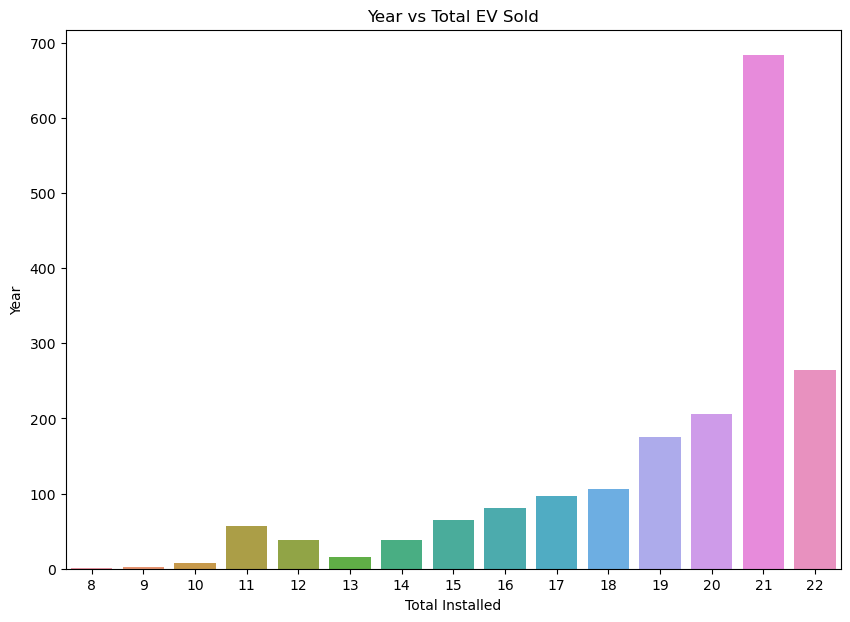

In [12]:
fig=plt.figure(figsize = (10, 7))
sns.barplot(x="Year", y="Total_Installed", data=df)
plt.title('Year vs Total EV Sold')
plt.xlabel('Total Installed')
plt.ylabel('Year')
plt.show()

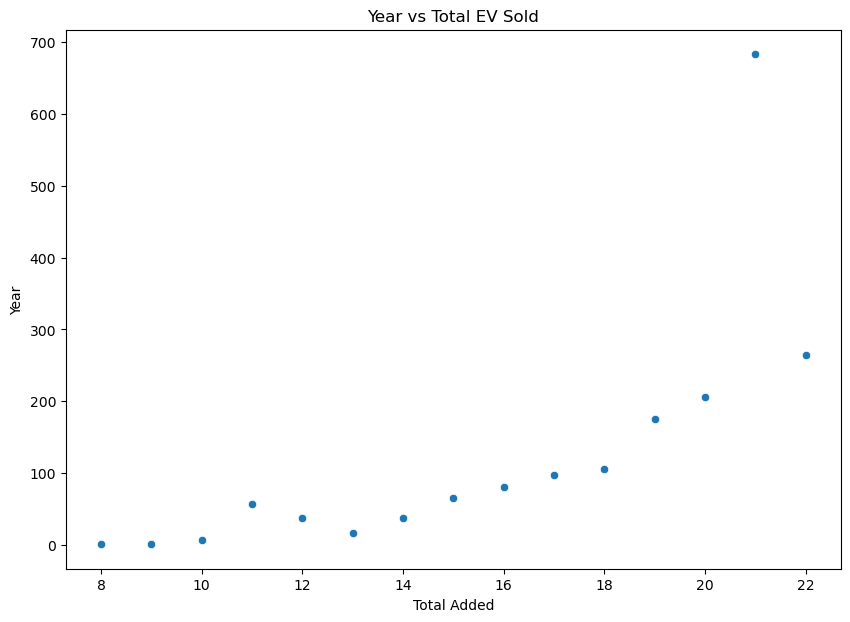

In [13]:
fig=plt.figure(figsize = (10, 7))
sns.scatterplot(x="Year", y="Total_Installed", data=df)
plt.title('Year vs Total EV Sold')
plt.xlabel('Total Added')
plt.ylabel('Year')
plt.show()

In [14]:
X=np.array(df["Year"].values)
y=np.array(df["Total_Installed"].values)

X=X.reshape(-1,1)
y=y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(X_train) 
xtest = sc_x.transform(X_test)
print (xtrain[0:10, :])

[[ 1.43109747]
 [-0.72535077]
 [-1.15664042]
 [ 1.21545265]
 [ 0.56851817]
 [-0.0784163 ]
 [ 0.784163  ]
 [-0.9409956 ]
 [-1.58793007]
 [-0.50970595]]


In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [16]:
classifier.predict(X_test)

array([  1.,  16.,  65., 106.])

<AxesSubplot:>

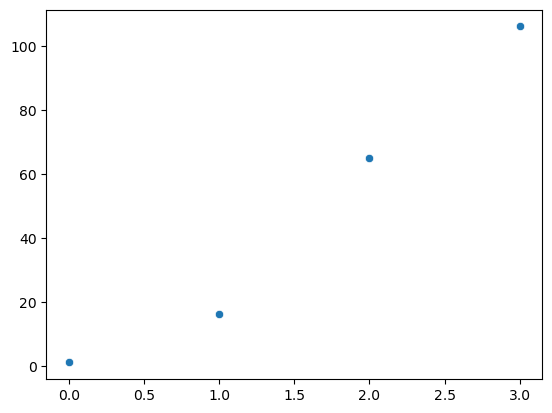

In [17]:
predictions = classifier.predict(X_test)
sns.scatterplot(predictions)

In [18]:
# create the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, y_train)

# use the model to make predictions on the test data
y_pred = model.predict(X_test)

# evaluate the model's performance
print("R2 score: ", model.score(X_test, y_test))


# make predictions on new data
new_data = pd.DataFrame([[1500, 3, 2]], columns=["sqft", "bedrooms", "bathrooms"])
predictions = model.predict(new_data)
print(predictions)


R2 score:  -3.2397892286312526


ValueError: X has 3 features, but LinearRegression is expecting 1 features as input.